In [33]:
import pandas as pd
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from estnltk import Text
import time

In [4]:
model = KeyedVectors.load_word2vec_format("../../../w2v-models/lemmas.sg.s100.w2v.bin", binary=True)

In [154]:
phrases=pd.read_csv('fragments.csv', sep=',',header=0, index_col=False)
print(phrases.shape)

(2595, 4)


In [155]:
phrases.head()

,pred_fragment,is_prd_by_gold,subj_is_first,malt_is_right
0,kes on lumeuurija,True,True,True
1,Eesti on koht,True,True,False
2,See on fenomen,True,True,True
3,vesi on vann,True,True,True
4,mäss on lugu,True,True,True


### Filtreeri välja fraasid, kus sõna on mudelist puudu

In [156]:
OK_for_WMD = []
prd_lemmas = []
for ix, row in phrases.iterrows():
    phrase = row["pred_fragment"]
    lemmas = Text(phrase).lemmas
    
    lemmas = [l.lower() for l in lemmas]
    
    try:
        model[lemmas]
        OK_for_WMD.append(True)
        prd_lemmas.append(" ".join(lemmas))
    except KeyError:
        OK_for_WMD.append(False)
        prd_lemmas.append(" ".join(lemmas))

In [157]:
OK_for_WMD.count(True), OK_for_WMD.count(False)

(2437, 158)

In [158]:
phrases['OK_for_WMD'] = pd.Series(OK_for_WMD, index=phrases.index)
phrases['lemma'] = pd.Series(prd_lemmas, index=phrases.index)
phrases.to_csv('fragments_checked.csv', index=False)
phrases.head()

,pred_fragment,is_prd_by_gold,subj_is_first,malt_is_right,OK_for_WMD,lemma
0,kes on lumeuurija,True,True,True,True,kes olema lumeuurija
1,Eesti on koht,True,True,False,True,eesti olema koht
2,See on fenomen,True,True,True,True,see olema fenomen
3,vesi on vann,True,True,True,True,vesi olema vann
4,mäss on lugu,True,True,True,True,mäss olema lugu


### Leia kaugusmaatriks

In [78]:
contexts = phrases[phrases["OK_for_WMD"] == True]["lemma"].values
assert(len(contexts) == OK_for_WMD.count(True))
contexts[:10]

array(['kes olema lumeuurija', 'eesti olema koht', 'see olema fenomen',
       'vesi olema vann', 'mäss olema lugu', 'osanik olema park',
       'isa olema arhitektuurifotograaf', 'ema olema rätsep',
       'nimi olema walter', 'film olema lõputöö'], dtype=object)

In [60]:
## %%timeit -n 1 -r 5

start = time.time()
D = np.zeros((len(contexts), len(contexts)))
for i in range(len(contexts)):
    if(i % 100 == 0):
        print("processed", (i*100)/len(contexts), "% words")
    for j in range(i+1):
        if i == j:
            continue  # self-distance is 0.0
        dist = round(model.wmdistance(contexts[i].split(), contexts[j].split()),10)
        D[i][j] = dist
        D[j][i] = dist
        
done = time.time()
elapsed = done - start

processed 0.0 % words
processed 4.1034058268362745 % words
processed 8.206811653672549 % words
processed 12.310217480508822 % words
processed 16.413623307345098 % words
processed 20.51702913418137 % words
processed 24.620434961017644 % words
processed 28.72384078785392 % words
processed 32.827246614690196 % words
processed 36.93065244152647 % words
processed 41.03405826836274 % words
processed 45.137464095199014 % words
processed 49.24086992203529 % words
processed 53.34427574887156 % words
processed 57.44768157570784 % words
processed 61.55108740254411 % words
processed 65.65449322938039 % words
processed 69.75789905621666 % words
processed 73.86130488305294 % words
processed 77.9647107098892 % words
processed 82.06811653672548 % words
processed 86.17152236356176 % words
processed 90.27492819039803 % words
processed 94.37833401723431 % words
processed 98.48173984407057 % words


In [61]:
np.save("distance_matrix_predicative.npy", D, False, False)


In [62]:
print("finding distance matrix took ", elapsed/60, "minutes")



finding distance matrix took  15.638903685410817 minutes


### 2d embedding

In [63]:
from sklearn import manifold

seed = np.random.RandomState(seed=3)
mds2 = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=-1)
mds_2d_no_verbs = mds2.fit(D).embedding_

In [64]:
np.save("mds2d_predicative.npy", mds_2d_no_verbs, False, False)

In [65]:
mds2d = mds_2d_no_verbs

In [79]:
mds2d.shape, D.shape, contexts.shape

((2437, 2), (2437, 2437), (2437,))

### Visualiseeri

In [160]:
mds2d = np.load("mds2d_predicative.npy")

In [161]:
from matplotlib import pyplot as plt

In [162]:
ctxt = phrases[phrases["OK_for_WMD"] == True].reset_index(drop=True)
ctxt.head()

,pred_fragment,is_prd_by_gold,subj_is_first,malt_is_right,OK_for_WMD,lemma
0,kes on lumeuurija,True,True,True,True,kes olema lumeuurija
1,Eesti on koht,True,True,False,True,eesti olema koht
2,See on fenomen,True,True,True,True,see olema fenomen
3,vesi on vann,True,True,True,True,vesi olema vann
4,mäss on lugu,True,True,True,True,mäss olema lugu


In [163]:
ctxt[ctxt["malt_is_right"] == False].shape

(578, 6)

In [164]:
def plotData(tag, title, ctxt):
    plt.figure(figsize=(8, 8), dpi=80)

    ix = ctxt[ctxt[tag] == True].index
    print(ix[-10:])
    plt.scatter(mds2d[ix, 0], mds2d[ix, 1], s=20, color="green", label="jah")

    ix = ctxt[ctxt[tag] == False].index
    plt.scatter(mds2d[ix, 0], mds2d[ix, 1], s=20, color="red", label="ei")
    plt.legend(loc = 3, prop={'size': 15})
    plt.axis('off')
    
    plt.title(title)
    plt.show()

Int64Index([2424, 2425, 2426, 2427, 2429, 2430, 2432, 2433, 2434, 2436], dtype='int64')


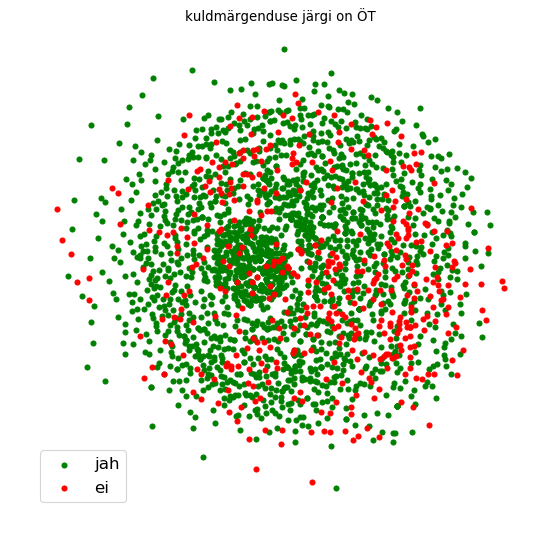

In [165]:
plotData("is_prd_by_gold", "kuldmärgenduse järgi on ÖT", ctxt)

Int64Index([2424, 2425, 2426, 2427, 2429, 2430, 2432, 2433, 2434, 2436], dtype='int64')


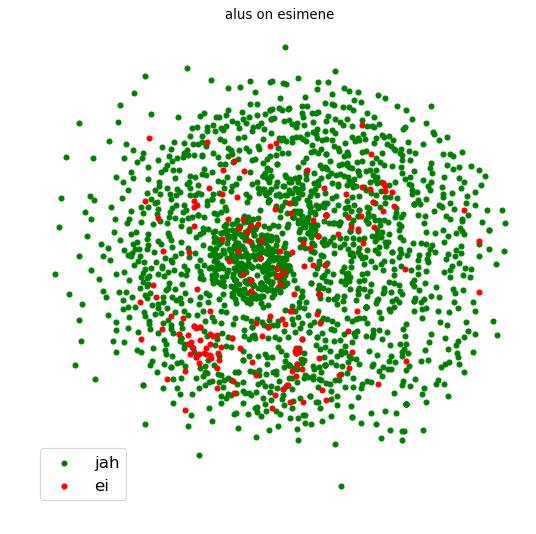

In [166]:
plotData("subj_is_first", "alus on esimene", ctxt)

Int64Index([2416, 2417, 2418, 2421, 2422, 2424, 2427, 2432, 2433, 2434], dtype='int64')


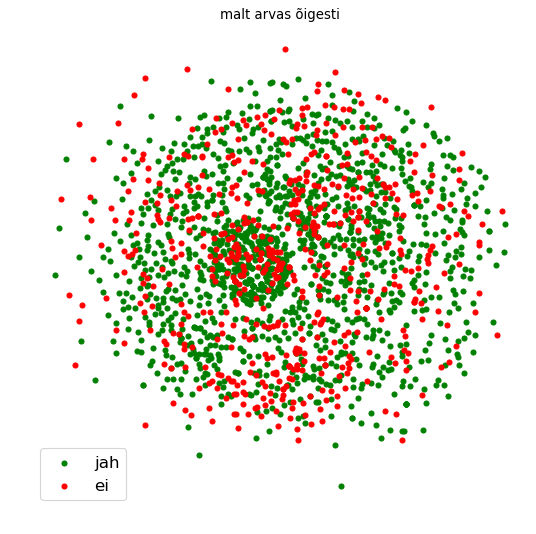

In [167]:
plotData("malt_is_right", "malt arvas õigesti", ctxt)

### Kernel-PCA 

In [168]:
from sklearn.decomposition import KernelPCA
def plotKPCA(tag, title, ctxt, gamma=0.1):
    kernel_matrix = np.exp(-gamma*(D ** 2))

    kpca = KernelPCA(kernel='precomputed', n_components=2)
    transformed = kpca.fit_transform(kernel_matrix)
    
    plt.figure(figsize=(8, 8), dpi=80)

    ix = ctxt[ctxt[tag] == True].index
    plt.scatter(transformed[ix, 0], transformed[ix, 1], s=20, color="green", label="jah")

    ix = ctxt[ctxt[tag] == False].index
    plt.scatter(transformed[ix, 0], transformed[ix, 1], s=20, color="red", label="ei")
    plt.legend(loc = 3, prop={'size': 15})
    plt.axis('off')
    
    plt.title(title)
    plt.show()

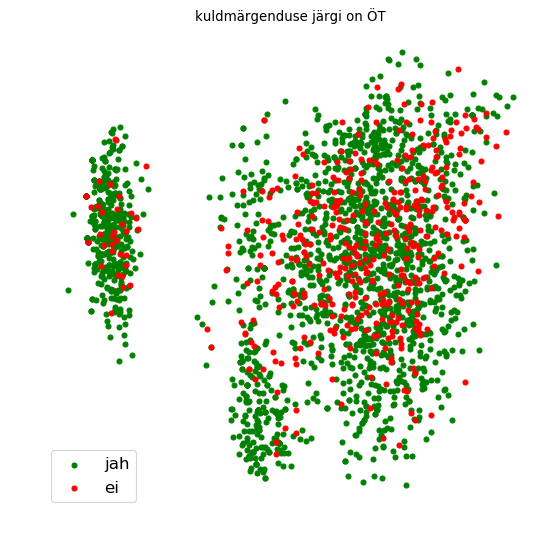

In [169]:
plotKPCA("is_prd_by_gold", "kuldmärgenduse järgi on ÖT", ctxt)

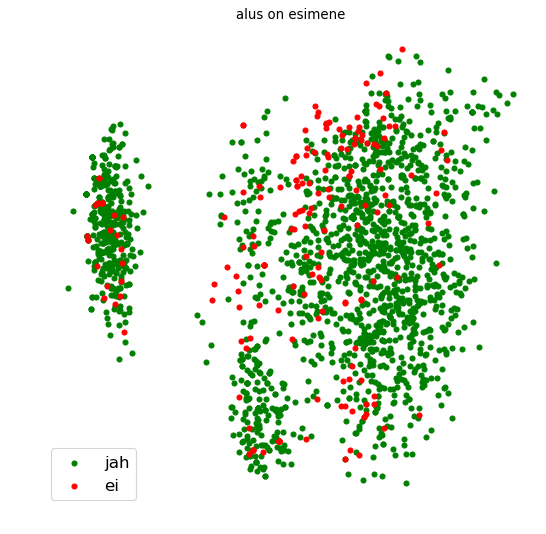

In [170]:
plotKPCA("subj_is_first", "alus on esimene", ctxt)

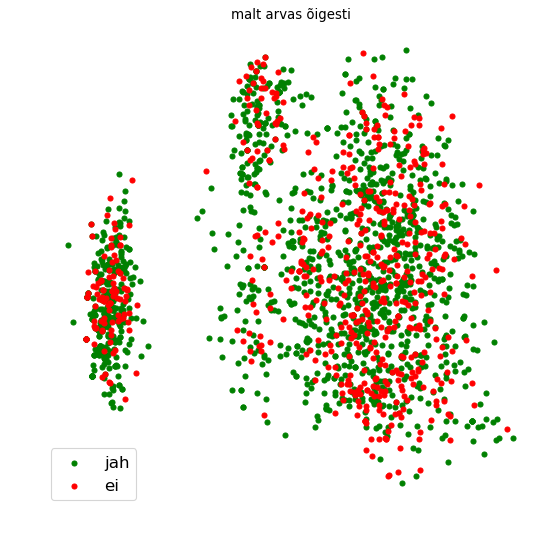

In [172]:
plotKPCA("malt_is_right", "malt arvas õigesti", ctxt)